# Análise de detecção de fraude em transações bancárias

### Problema

<p style="text-align: justify">Com o processo de digitalização da economia, as instituições financeiras têm lidado com o problema cada vez mais comum que são as fraudes em suas transações. Segundo reportagem da <a href="https://exame.com/future-of-money/cybersecurity/na-pandemia-fraudes-com-servicos-financeiros-aumentam-457-no-brasil/">Exame</a>, o número de fraudes com serviços financeiros cresceu 457% no Brasil durante a pandemia, sendo que o crescimento mudial foi 57,5%. Dessa maneira, soluções que busquem identificar esse tipo de transação antes que as mesmas aconteçam, seria de grande valia para empresas e clientes.</p>

### Solução

<p style="text-align: justify">Diante do problema relatado acima, será realizado uma análise de detecção de fraude através de um modelo de <i>machine learning</i>,  utilizando redes neurais artificiais (<i>Deep Learning</i>). Para isso, foi utilizado o seguinte conjunto de dados do site <a href="https://www.kaggle.com/ealaxi/paysim1">Kaggle</a>. 

**As descrições dos atributos do conjunto de dados segue abaixo:**

**step** - Mapa de unidade de tempo no mundo real. Caso 1 é uma hora do tempo, sendo o total de steps é igual a 744 (30 dias).

**type** - Tipos diferentes de pagamento.

**amount** - Valor da transação na moeda local.

**nameOrig** - Cliente que iniciou a transação.

**oldbalanceOrg** - Saldo inicial antes da transação.

**newbalanceOrig** - Saldo depois da transação.

**nameDest** - Cliente que é destinatário da transação.

**oldbalanceDest** - Destinatário do saldo inicial antes da transação.

**newbalanceDest** - Saldo do destinatário depois da transação

**isFraud** - Transações feitas por agentes fraudulentos (0 = Normal, 1 = Fraude)

**isFlaggedFraud** - Tentativa de transferir mais de 200.000 em uma única transação (0 = Não, 1 = Sim)


<p style='color:red'><b>Referência do banco de dados:</b></p>

*PaySim first paper of the simulator:*

*E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016*</p>

### Importando bibliotecas

In [1]:
#Bibliotecas para tratamento dos dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Bibliotecas para pré-processamento dos dados
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler

#Bibliotecas para construção dos modelos
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


#Bibliotecas para avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


%matplotlib inline
pd.options.display.float_format = '{:20,.4f}'.format
import warnings
warnings.filterwarnings('ignore')

### Análise exploratória dos dados

In [2]:
#Carregando o conjunto de dados
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
#Visualizando o conjunto de dados 
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6400",C1231006815,"170,136.0000","160,296.3600",M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,"1,864.2800",C1666544295,"21,249.0000","19,384.7200",M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,"21,182.0000",0.0000,1,0
4,1,PAYMENT,"11,668.1400",C2048537720,"41,554.0000","29,885.8600",M1230701703,0.0000,0.0000,0,0


##### Verificando tamanho do conjunto de dados

In [3]:
print("\nNúmero de linhas: {}".format(df.shape[0]),'\n')
print("Número de colunas: {}".format(df.shape[1]),'\n')
print("Número de classes por coluna:\n{}".format(df.nunique()))


Número de linhas: 6362620 

Número de colunas: 11 

Número de classes por coluna:
step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


##### Verificando tipos dos atributos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


##### Verificando a existência de valores nulos nos atributos

In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

##### Verificando a existência de valores duplicados nos atributos

In [7]:
print("Valores duplicados: {}".format(df.duplicated().sum()))

Valores duplicados: 0


##### Verificando quantidade dos tipos de transações

In [8]:
print('\nTransações normais: {}'.format(df['isFraud'].value_counts()[0]),'\n')
print('Transações fraudulentas: {}'.format(df['isFraud'].value_counts()[1]),'\n')
print('Porcentagem de transações normais: {0:.2f}%'.format((df['isFraud'].value_counts()[0]/df.shape[0])*100),'\n')
print('Porcentagem de transações fraudulentas:{0:.2f}%'.format((df['isFraud'].value_counts()[1]/df.shape[0])*100))


Transações normais: 6354407 

Transações fraudulentas: 8213 

Porcentagem de transações normais: 99.87% 

Porcentagem de transações fraudulentas:0.13%


<p style="text-align: justify">Como pode ser percebido, existem poucos dados de transações fraudulentas quando comparadas a transações normais. Isso pode ser um problema para o modelo de machine learning, pois o modelo pode ter a capacidade de identicar melhor a classe com o maior número de instâncias (transações normais).</p> 

##### Verificando estatísticas descritivas dos atributos

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000","6,362,620.0000"
mean,243.3972,"179,861.9035","833,883.1041","855,113.6686","1,100,701.6665","1,224,996.3982",0.0013,0.0000
std,142.3320,"603,858.2315","2,888,242.6730","2,924,048.5030","3,399,180.1130","3,674,128.9421",0.0359,0.0016
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,156.0000,"13,389.5700",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,239.0000,"74,871.9400","14,208.0000",0.0000,"132,705.6650","214,661.4400",0.0000,0.0000
75%,335.0000,"208,721.4775","107,315.1750","144,258.4100","943,036.7075","1,111,909.2500",0.0000,0.0000
max,743.0000,"92,445,516.6400","59,585,040.3700","49,585,040.3700","356,015,889.3500","356,179,278.9200",1.0000,1.0000


### Perfil geral das transações

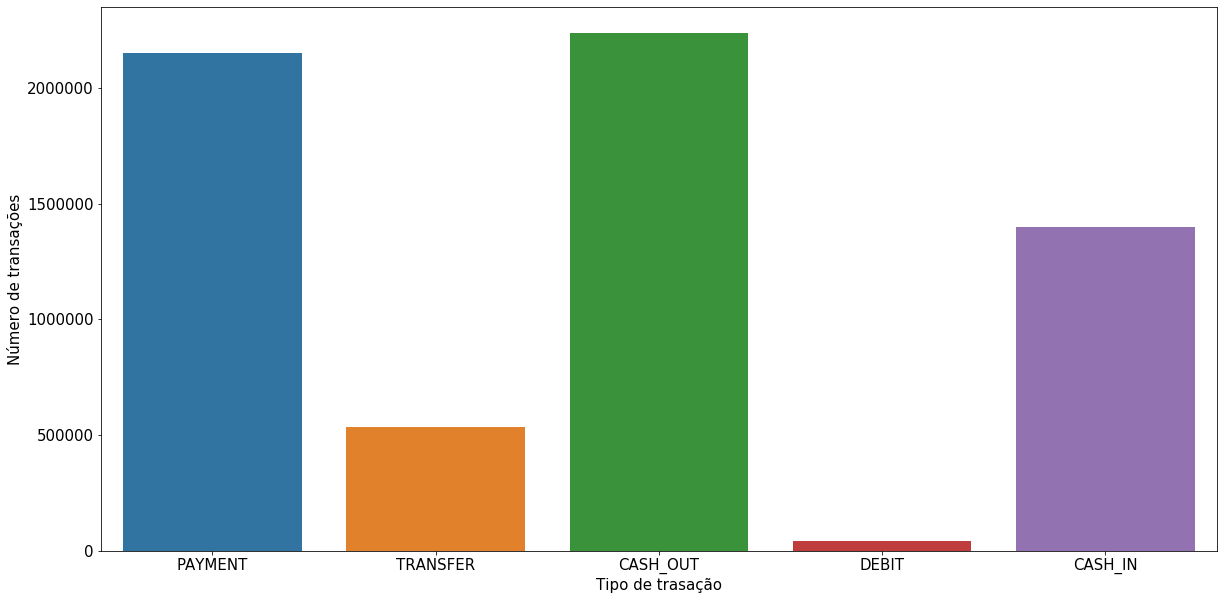

In [10]:
#Manipulando o tamanho do gráfico
plt.figure(figsize=(20,10))
#Construindo gráfico de barra das transações
sns.countplot('type',data=df)
plt.xlabel("Tipo de trasação",fontsize=15)
plt.ylabel('Número de transações',fontsize=15)
plt.tick_params(labelsize = 15);

<b>Os tipos de transações com maior número foram saques (*Cash out*), pagamentos (*payment*) e depósitos (*Cash in*) respectivamente.</b>

### Perfil de transações normais

In [11]:
#Separando os dados com transações normais
df_norm = df[df['isFraud'] == 0]

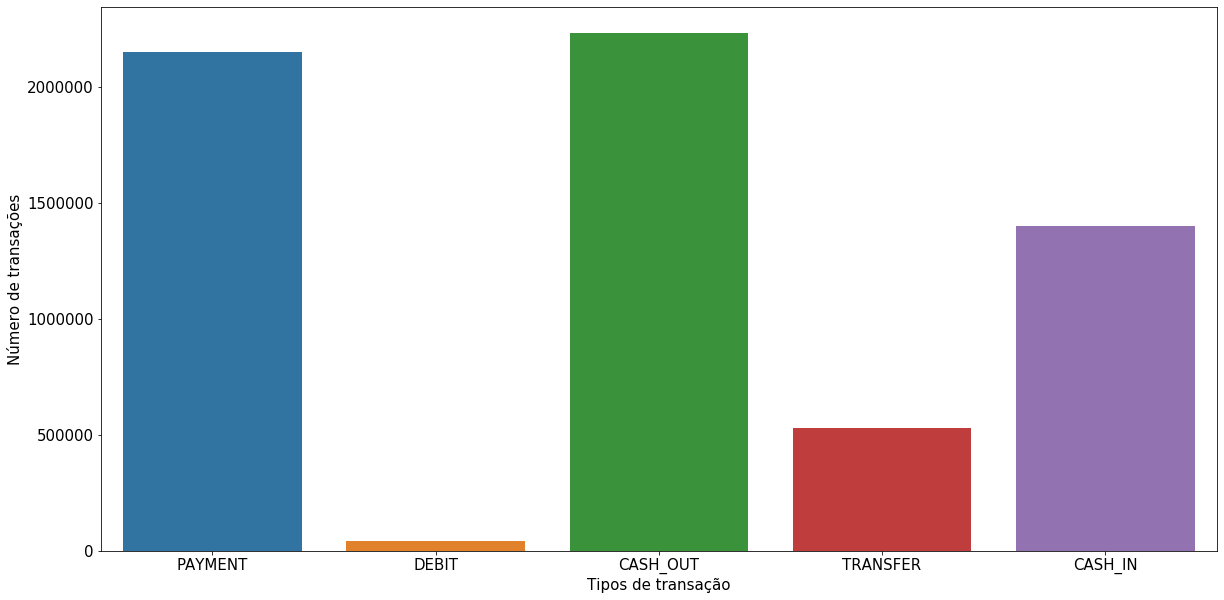

In [12]:
#Manipulando o tamanho do gráfico
plt.figure(figsize=(20,10))
#Construindo gráfico de barra das transações
sns.countplot('type',data=df_norm)
plt.xlabel("Tipos de transação",fontsize=15)
plt.ylabel('Número de transações',fontsize=15)
plt.tick_params(labelsize = 15);

<b>Para transações normais, os tipos de transações com maior número também foram *saques, pagamentos e depósitos* respectivamente.</b>

### Perfil de transações fraudulentas

In [14]:
#Separando os dados com transações normais
df_fraud = df[df['isFraud'] == 1]

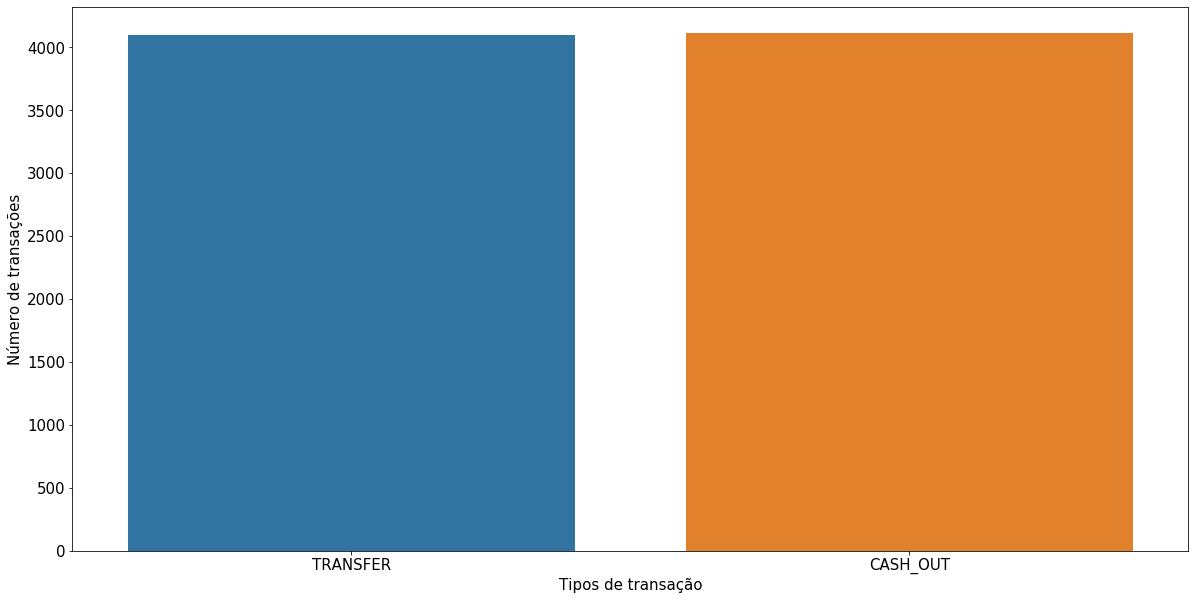

In [15]:
#Manipulando o tamanho do gráfico
plt.figure(figsize=(20,10))
#Construindo gráfico de barra das transações
sns.countplot('type',data=df_fraud)
plt.xlabel("Tipos de transação",fontsize=15)
plt.ylabel('Número de transações',fontsize=15)
plt.tick_params(labelsize = 15);

<b>Já para transações fraudulentas, somente dois tipos de transações foram feitas, transferências (*transfer*) e saques (*cash out*).</b>

### Pré-processamento das variáveis

##### Retirando atributos que não serão utilizados no modelo

In [16]:
#Eliminando atributos que não serão usados
df2 = df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
#Verificando o cabeçalho dos gráficos
df2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,"9,839.6400","170,136.0000","160,296.3600",0.0000,0.0000,0
1,1,PAYMENT,"1,864.2800","21,249.0000","19,384.7200",0.0000,0.0000,0
2,1,TRANSFER,181.0000,181.0000,0.0000,0.0000,0.0000,1
3,1,CASH_OUT,181.0000,181.0000,0.0000,"21,182.0000",0.0000,1
4,1,PAYMENT,"11,668.1400","41,554.0000","29,885.8600",0.0000,0.0000,0


##### One hot encoding

<p style="text-align: justify">Como o atributo *type* é uma variável categórica nominal, será realizado a técnica de *one hot encoding*, onde cada uma das classes do atributo irá se transformar em um atributo binário.</p>

In [17]:
#Criando uma lista com o nome das colunas 
categorical = ['type']
#Transformando variáveis categóricas em binárias
df2 = pd.get_dummies(df2, columns=categorical)
#Verificando o cabeçalho dos gráficos
df2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,"9,839.6400","170,136.0000","160,296.3600",0.0000,0.0000,0,0,0,0,1,0
1,1,"1,864.2800","21,249.0000","19,384.7200",0.0000,0.0000,0,0,0,0,1,0
2,1,181.0000,181.0000,0.0000,0.0000,0.0000,1,0,0,0,0,1
3,1,181.0000,181.0000,0.0000,"21,182.0000",0.0000,1,0,1,0,0,0
4,1,"11,668.1400","41,554.0000","29,885.8600",0.0000,0.0000,0,0,0,0,1,0


##### Normalização

<p style="text-align: justify">Como as variáveis contínuas possuem escalas de valores distintos, será realizado uma normalização dos valores para que os atributos com maior escala não influenciem na classificação do modelo.</p>

In [18]:
#Criando uma lista com as variáveis categóricas
atribu = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT','type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
#Padronizando as variáveis
scale = MinMaxScaler()
df2[atribu] = scale.fit_transform(df2[atribu])
#Verificando o cabeçalho dos dados
df2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.0000,0.0001,0.0029,0.0032,0.0000,0.0000,0,0.0000,0.0000,0.0000,1.0000,0.0000
1,0.0000,0.0000,0.0004,0.0004,0.0000,0.0000,0,0.0000,0.0000,0.0000,1.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,0.0000,0.0000,0.0000,1.0000
3,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,1,0.0000,1.0000,0.0000,0.0000,0.0000
4,0.0000,0.0001,0.0007,0.0006,0.0000,0.0000,0,0.0000,0.0000,0.0000,1.0000,0.0000


##### Verificando o tamanho do conjunto de dados depois do pré-processamento

In [19]:
print("Número de linhas: {}".format(df2.shape[0]),'\n')
print("Número de colunas: {}".format(df2.shape[1]))

Número de linhas: 6362620 

Número de colunas: 12


##### Separando os dados do modelo

In [22]:
x = df2.drop('isFraud', axis=1)
y = df2['isFraud']

0    6354407
1       8213
Name: isFraud, dtype: int64


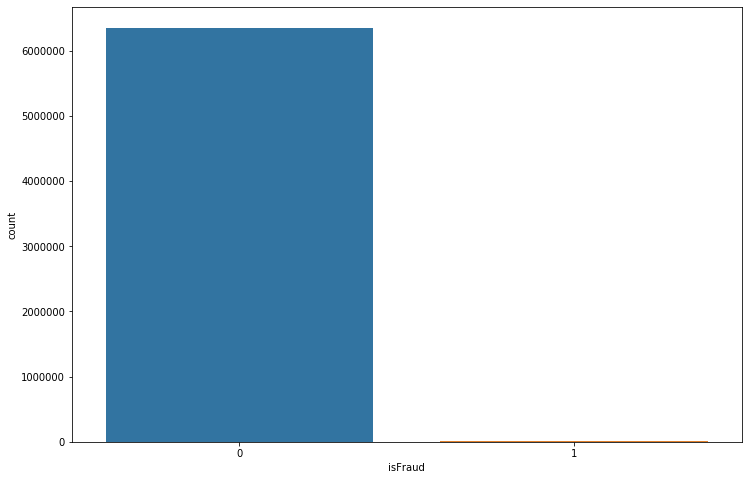

In [23]:
#Verificando tamanho das classes
plt.figure(figsize=(12,8))
print(pd.Series(y.value_counts()))
sns.countplot(y);

<p style="text-align: justify">Como relatado anteriormente, o número de transações normais é muito maior do que número de transações fraudulentes e isto pode influenciar na performance do modelo. Dessa maneira, será realizado um modelo com os dados desbalanceados e posteriomente será realizado uma outra análise utilizando os dados balanceados.</p>

### Separando dados de treino e teste

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state = 42)

In [25]:
#Verificando o tamanho dos dados de treino
print(x_train.shape)
print(y_train.shape)

(4453834, 11)
(4453834,)


### Estrutura da rede

<p style="text-align: justify">A rede neural será composta de uma camada de entrada, uma camada oculta e uma camada de saída. A camada de entrada e oculta possuirão 7 "neurônios"(<i>units</i>), enquanto a camada de saída terá 1. A função de ativação para a camada de entrada e a oculta será a relu. Essa função transforma entradas negativas em zero e não satura para valores de entrada grandes. Para a camada de saída, será utilizada a função sigmóide, por ser um problema de classificação, e os valores dos pesos iniciarão de maneira aleatória dentro de uma distribuição uniforme (<i>kernel_initializer</i>). O número de entradas na camada de entrada (<i>input_dim</i>) é correspondente ao número de atributos que serão utilizados na análise. O otimizador será o Adam, que possui um bom desempenho em diversas análises, a função de custo utilizada será a <i>binary_crossentropy</i>, por ser um problema de classificação, e a métrica de avaliação da rede será a acurácia(<i>binary_accuracy</i>).</p>   

In [26]:
clf_cred = Sequential()

clf_cred.add(Dense(units = 7, activation = 'relu', kernel_initializer = 'random_uniform', input_dim = 11 ))
clf_cred.add(Dense(units = 7, activation = 'relu', kernel_initializer = 'random_uniform' ))
clf_cred.add(Dense(units = 1, activation = 'sigmoid'))

clf_cred.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
clf_cred.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 84        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


### Treinando a rede

<p style="text-align: justify">A rede será executada em lotes de 1000 instâncias (<i>batch_size</i>) e 100 iterações de treinamento(<i>epochs</i>) devido ao número grande de instâncias no conjunto de dados (4.453.834). Se o lote de instâncias  fosse menor e número de iterações de treinamento maior, o tempo de processamento da rede seria muito grande.<p>

In [27]:
batch_size = 1000
epochs = 100

clf_cred.fit(x_train, y_train,batch_size = batch_size, epochs = epochs)

Epoch 1/100
4454/4454 [==============================] - 6s 1ms/step - loss: 0.0418 - binary_accuracy: 0.9984
Epoch 2/100
4454/4454 [==============================] - 7s 1ms/step - loss: 0.0079 - binary_accuracy: 0.9987
Epoch 3/100
4454/4454 [==============================] - 7s 1ms/step - loss: 0.0069 - binary_accuracy: 0.9987
Epoch 4/100
4454/4454 [==============================] - 6s 1ms/step - loss: 0.0062 - binary_accuracy: 0.9989
Epoch 5/100
4454/4454 [==============================] - 7s 2ms/step - loss: 0.0054 - binary_accuracy: 0.9990
Epoch 6/100
4454/4454 [==============================] - 6s 1ms/step - loss: 0.0049 - binary_accuracy: 0.9991
Epoch 7/100
4454/4454 [==============================] - 7s 2ms/step - loss: 0.0047 - binary_accuracy: 0.9991
Epoch 8/100
4454/4454 [==============================] - 6s 1ms/step - loss: 0.0045 - binary_accuracy: 0.9992
Epoch 9/100
4454/4454 [==============================] - 6s 1ms/step - loss: 0.0043 - binary_accuracy: 0.9992
Epoch 10/1

Acurácia: 99.95% 

Sensibilidade: 61.72% 

Precisão: 97.28% 

F1-score: 0.76 

Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.62      0.76      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.81      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



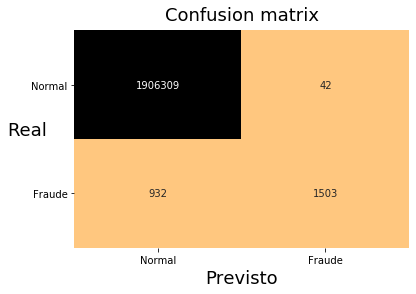

In [28]:
predictions = clf_cred.predict(x_test)
predictions = (predictions > 0.5)

print("Acurácia: {0:.2f}%".format(100 * accuracy_score(y_test,predictions)),'\n')
print("Sensibilidade: {0:.2f}%".format(100* recall_score(y_test,predictions)),'\n')
print("Precisão: {0:.2f}%".format(100* precision_score(y_test,predictions)),'\n')
print("F1-score: {0:.2f}".format(f1_score(y_test,predictions)),'\n')
print("Relatório de classificação:\n{}".format(classification_report(y_test,predictions)))

cm=confusion_matrix(y_test,predictions)
ax = sns.heatmap(cm,annot=True,cbar=False, fmt ='d', cmap="copper_r")
ax.set_title('Confusion matrix', fontsize=18,pad=10)
ax.set_xlabel('Previsto', fontsize=18)
ax.set_ylabel('Real', fontsize=18,rotation=0)
ax.set_xticklabels(['Normal','Fraude'])
ax.set_yticklabels(['Normal','Fraude'], rotation=0);

<p style="text-align: justify">O modelo teve acurácia de 99.95%, entretanto está não é a melhor métrica para avaliar o modelo. Como previsto, o modelo foi bastante sensível e preciso para encontrar as transações normais (<i>Recall</i> e <i>Precison</i>), mas para detectar as transações fraudulentas, o modelo teve 70% de performance com uma precisão de 98%. Ou seja, o modelo classifica as trasanções fraudulentas em 62% das vezes, e dessas, é assertivo em 97%. Além disso, o modelo possui um <i>f1-score</i> de 88%, que avalia a média harmônica entre a sensibilidade e precisão. Logo, apesar do modelo ter uma boa precisão para as fraudes, o mesmo não está tendo um desempenho satisfatório para encontrar essas transações fraudulentas. Isso porque o número de falsos positivos(transações fraudulentas que são consideradas normais) ainda é grande(932), e isso pode ter um custo alto para a empresa. Assim, será realizado um balanceamento dos dados com a finalidade de tentar melhorar a performance do modelo para a classe de interesse (transações fraudulentas).</p> 

### Random Under Sampling

<p style="text-align: justify">Esta técnica consiste em retirar instâncias da classe majoritária de maneira aleatória a fim de balancear o conjuto de dados entre as duas classes. Apesar de diminuir a classe majoritária (transações normais), o grande número de instâncias desta classe ainda permite deixar o conjunto de dados com um grande número de instâncias.</p>

##### Undersampling

In [29]:
#Balanceando as classes 
us = RandomUnderSampler(sampling_strategy="majority", random_state=42)
x_us,y_us = us.fit_sample(x,y)

0    8213
1    8213
Name: isFraud, dtype: int64


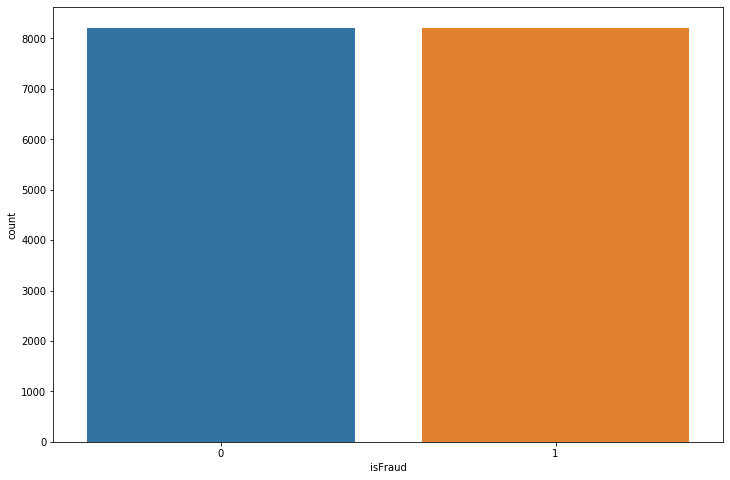

In [30]:
#Criando um gráfico das classes balanceadas 
plt.figure(figsize=(12,8))
print(pd.Series(y_us.value_counts()))
sns.countplot(y_us);

Agora com o conjunto de dados balanceado será realizado novamente a análise com a rede neural.

### Separando dados de treino e teste

In [31]:
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x_us,y_us, test_size= 0.3, random_state = 42)

In [32]:
print(x_train_us.shape)
print(y_train_us.shape)

(11498, 11)
(11498,)


### Rede neural - dados balanceados

<p style="text-align: justify">Com a retirada de algumas instâncias devido o balanceamento dos dados, será diminuído lote de instâncias (*batch_size*) e será aumentado o número de iterações de treinamento(*epochs*) da rede neural.</p> 

In [33]:
batch_size = 10
epochs = 100

clf_cred.fit(x_train_us, y_train_us,batch_size = batch_size, epochs = epochs)

Epoch 1/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0770 - binary_accuracy: 0.9750
Epoch 2/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0645 - binary_accuracy: 0.9780
Epoch 3/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0639 - binary_accuracy: 0.9778
Epoch 4/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0605 - binary_accuracy: 0.9816
Epoch 5/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0620 - binary_accuracy: 0.9792
Epoch 6/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0615 - binary_accuracy: 0.9806
Epoch 7/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0604 - binary_accuracy: 0.9799
Epoch 8/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0607 - binary_accuracy: 0.9803A: 1s - loss: 0.0731 -
Epoch 9/100
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0607 - binary_accur

Accuracy: 97.91% 

Sensibilidade: 96.37% 

Precisão: 99.41% 

F1-score: 97.86 

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2479
           1       0.99      0.96      0.98      2449

    accuracy                           0.98      4928
   macro avg       0.98      0.98      0.98      4928
weighted avg       0.98      0.98      0.98      4928



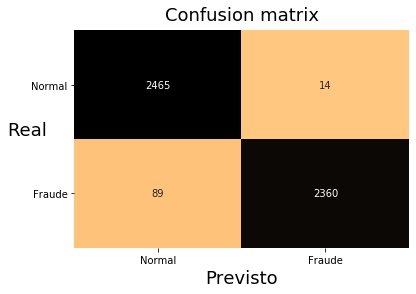

In [34]:
predictions_us = clf_cred.predict(x_test_us)
predictions_us = (predictions_us > 0.5)

print("Accuracy: {0:.2f}%".format(100 * accuracy_score(y_test_us,predictions_us)),'\n')
print("Sensibilidade: {0:.2f}%".format(100* recall_score(y_test_us,predictions_us)),'\n')
print("Precisão: {0:.2f}%".format(100* precision_score(y_test_us,predictions_us)),'\n')
print("F1-score: {0:.2f}".format(100* f1_score(y_test_us,predictions_us)),'\n')
print("Relatório de classificação:\n{}".format(classification_report(y_test_us,predictions_us)))

cm=confusion_matrix(y_test_us,predictions_us)
ax = sns.heatmap(cm,annot=True,cbar=False, fmt ='d', cmap="copper_r")
ax.set_title('Confusion matrix', fontsize=18,pad=10)
ax.set_xlabel('Previsto', fontsize=18)
ax.set_ylabel('Real', fontsize=18,rotation=0)
ax.set_xticklabels(['Normal','Fraude'])
ax.set_yticklabels(['Normal','Fraude'], rotation=0);

<p style="text-align: justify">A partir do balanceamento dos dados, houve uma melhora siginificativa na classe de interesse (transações fraudulentas). O modelo com os dados balanceados teve uma melhora significativa na sensibilidade (96% contra 62%) e  em precisão (99% contra 97%) quando comparado ao modelo desbalanceado. Além disso, f1-score foi de 98% contra 88% do modelo não balanceado. Dessa forma, o balanceamento dos dados foi de extrema importância para uma melhor performance da rede neural para detecção das fraudes.</p> 

### Conclusão

<p style="text-align: justify">A partir da análise dos dados, foi possível construir um modelo de detecção de fraudes com uma boa performance. O balanceamento dos dados realizado, possibilitou uma melhora significativa nas métricas do modelo, sendo importante em análises com essa composição dos dados. É importante destacar que redes neurais são normalmente utilizadas em problemas com uma maior complexidade e que outros algoritmos de machine learning (ex. Random Forest e XGBoost) poderiam conseguir resultados semelhantes como este em um tempo de processamento menor. Entretanto, o uso da rede neural com poucas camadas foi bastante satisfatório, mostrando o poder que esse tipo de algoritmos pode desempenhar em problemas como este.</p>